In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd

fake_dir = "E:\\College\\5th Sem\\ML\\Lab\\MLProject\\train\\FAKE"
real_dir = "E:\\College\\5th Sem\\ML\\Lab\\MLProject\\train\\REAL"
    
num_images_to_load = 10000

In [2]:
def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [3]:
def n_blocks(arr, tile_size=4):
    rows, cols = arr.shape

    tilings = [arr[i:i + tile_size, j:j + tile_size] for i in range(0, rows, tile_size) for j in range(0, cols, tile_size)]
    # print(tilings)
    return np.array(tilings)

In [4]:
def block_mean_var(arr):
    means_vars = []
    for block in arr:
        means_vars.append([np.mean(block) , np.var(block)])
    return np.array(means_vars)

In [5]:
def img_features(img):
    blocks = n_blocks(img)
    return block_mean_var(blocks)

In [6]:
def load_img_and_extract_features(filepath, label):
    img = cv2.imread(filepath)
    gray_img = to_gray(img)
    features = img_features(gray_img)
    return [i[0] for i in features],[i[1] for i in features], label

In [7]:
def load_imgs_from_directory(directory, label, num_images=None):
    images_m = []
    images_v = []
    labels = []
    files = os.listdir(directory)
    
        
    for i in files[:num_images]:
        mean, var, lbl = load_img_and_extract_features(os.path.join(directory, i), label)
        images_m.append(mean)
        images_v.append(var)
        labels.append(lbl)
    return images_m, images_v, labels

Mean of 1th block of real images :- 133.39768125
Mean of 1th block of fake images :- 102.15253125
Std of 1th block of real images :- 67.82628748673167
Std of 1th block of fake images :- 55.80225339381152
Mean of 2th block of real images :- 134.60771875
Mean of 2th block of fake images :- 109.4345125
Std of 2th block of real images :- 65.41746641904227
Std of 2th block of fake images :- 53.556349643796615
Mean of 3th block of real images :- 136.42166875
Mean of 3th block of fake images :- 112.78051875
Std of 3th block of real images :- 63.696315310519715
Std of 3th block of fake images :- 52.21041391657677
Mean of 4th block of real images :- 137.201425
Mean of 4th block of fake images :- 114.43456875
Std of 4th block of real images :- 63.26674892370893
Std of 4th block of fake images :- 51.49701636155389
Mean of 5th block of real images :- 137.35331875
Mean of 5th block of fake images :- 114.5045
Std of 5th block of real images :- 63.16071521079399
Std of 5th block of fake images :- 51.

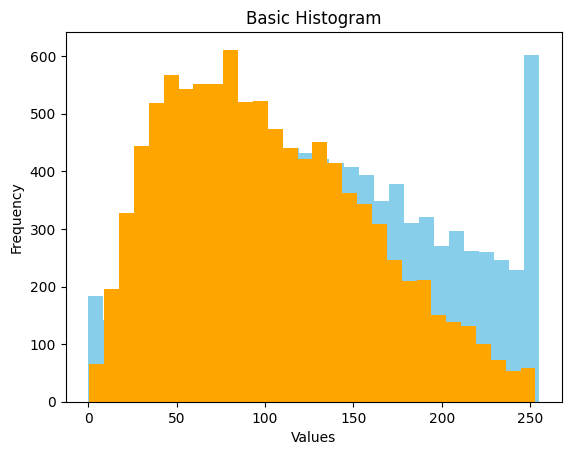

In [9]:
import matplotlib.pyplot as plt 

fake_images_m,fake_images_v, fake_labels = load_imgs_from_directory(fake_dir, 0, num_images=num_images_to_load)
real_images_m,real_images_v, real_labels = load_imgs_from_directory(real_dir, 1, num_images=num_images_to_load)
# print(len(real_images_m))
for j in range(8):
    a=[i[j] for i in real_images_m]
    b=[i[j] for i in fake_images_m]
    print("Mean of "+str(j+1)+"th block of real images :- " + str(np.mean(a)))
    print("Mean of "+str(j+1)+"th block of fake images :- " + str(np.mean(b)))
    print("Std of "+str(j+1)+"th block of real images :- " + str(np.std(a)))
    print("Std of "+str(j+1)+"th block of fake images :- " + str(np.std(b)))
    # print("Distance between "+str(j+1)+"th block mean of fake images and real :- " + str(np.linalg.norm(a-b)))


a=[i[0] for i in real_images_m]
b=[i[0] for i in fake_images_m]
plt.hist(x=a, bins=30, color='skyblue')
plt.hist(x=b, bins=30, color='orange')
 
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')
plt.show()

features_m = np.vstack((fake_images_m, real_images_m))
features_v = np.vstack((fake_images_v, real_images_v))
labels = np.concatenate((fake_labels, real_labels))

In [10]:
def feature_vec(mean, var):
    a=[]
    for i,j in zip(mean, var):
        b=[]
        for k,l in zip(i,j):
            b.append(k)
            b.append(l)
        a.append(b)
    return a

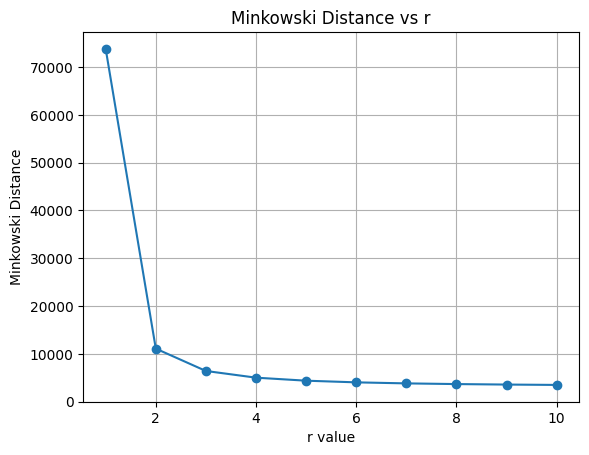

In [11]:
from scipy.spatial.distance import minkowski
import matplotlib.pyplot as plt
real_feat_vec = feature_vec(real_images_m, real_images_v)
fake_feat_vec = feature_vec(fake_images_m, fake_images_v)

r_values = range(1, 11)
distances = [minkowski(real_feat_vec[0], fake_feat_vec[0], r) for r in r_values]

plt.plot(r_values, distances, marker='o')
plt.xlabel('r value')
plt.ylabel('Minkowski Distance')
plt.title('Minkowski Distance vs r')
plt.grid(True)
plt.show()

In [12]:
x_train, x_test, y_train, y_test = train_test_split(features_m, labels, test_size=0.5, random_state=5)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

accuracy = knn.score(x_test, y_test)
print("Accuracy:", accuracy)

training_accuracy = knn.score(x_train, y_train)
print(f"Training Accuracy: {training_accuracy}")
predictions = knn.predict(x_test[:20])
actual_labels = y_test[:20]

# for i in range(len(predictions)):
#     print(f"Predicted: {predictions[i]}\tActual: {actual_labels[i]}")   

predicted_vs_actual = pd.DataFrame({"Actual": actual_labels, "Predicted": predictions})
predicted_vs_actual

Accuracy: 0.6607
Training Accuracy: 0.8249


,Actual,Predicted
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


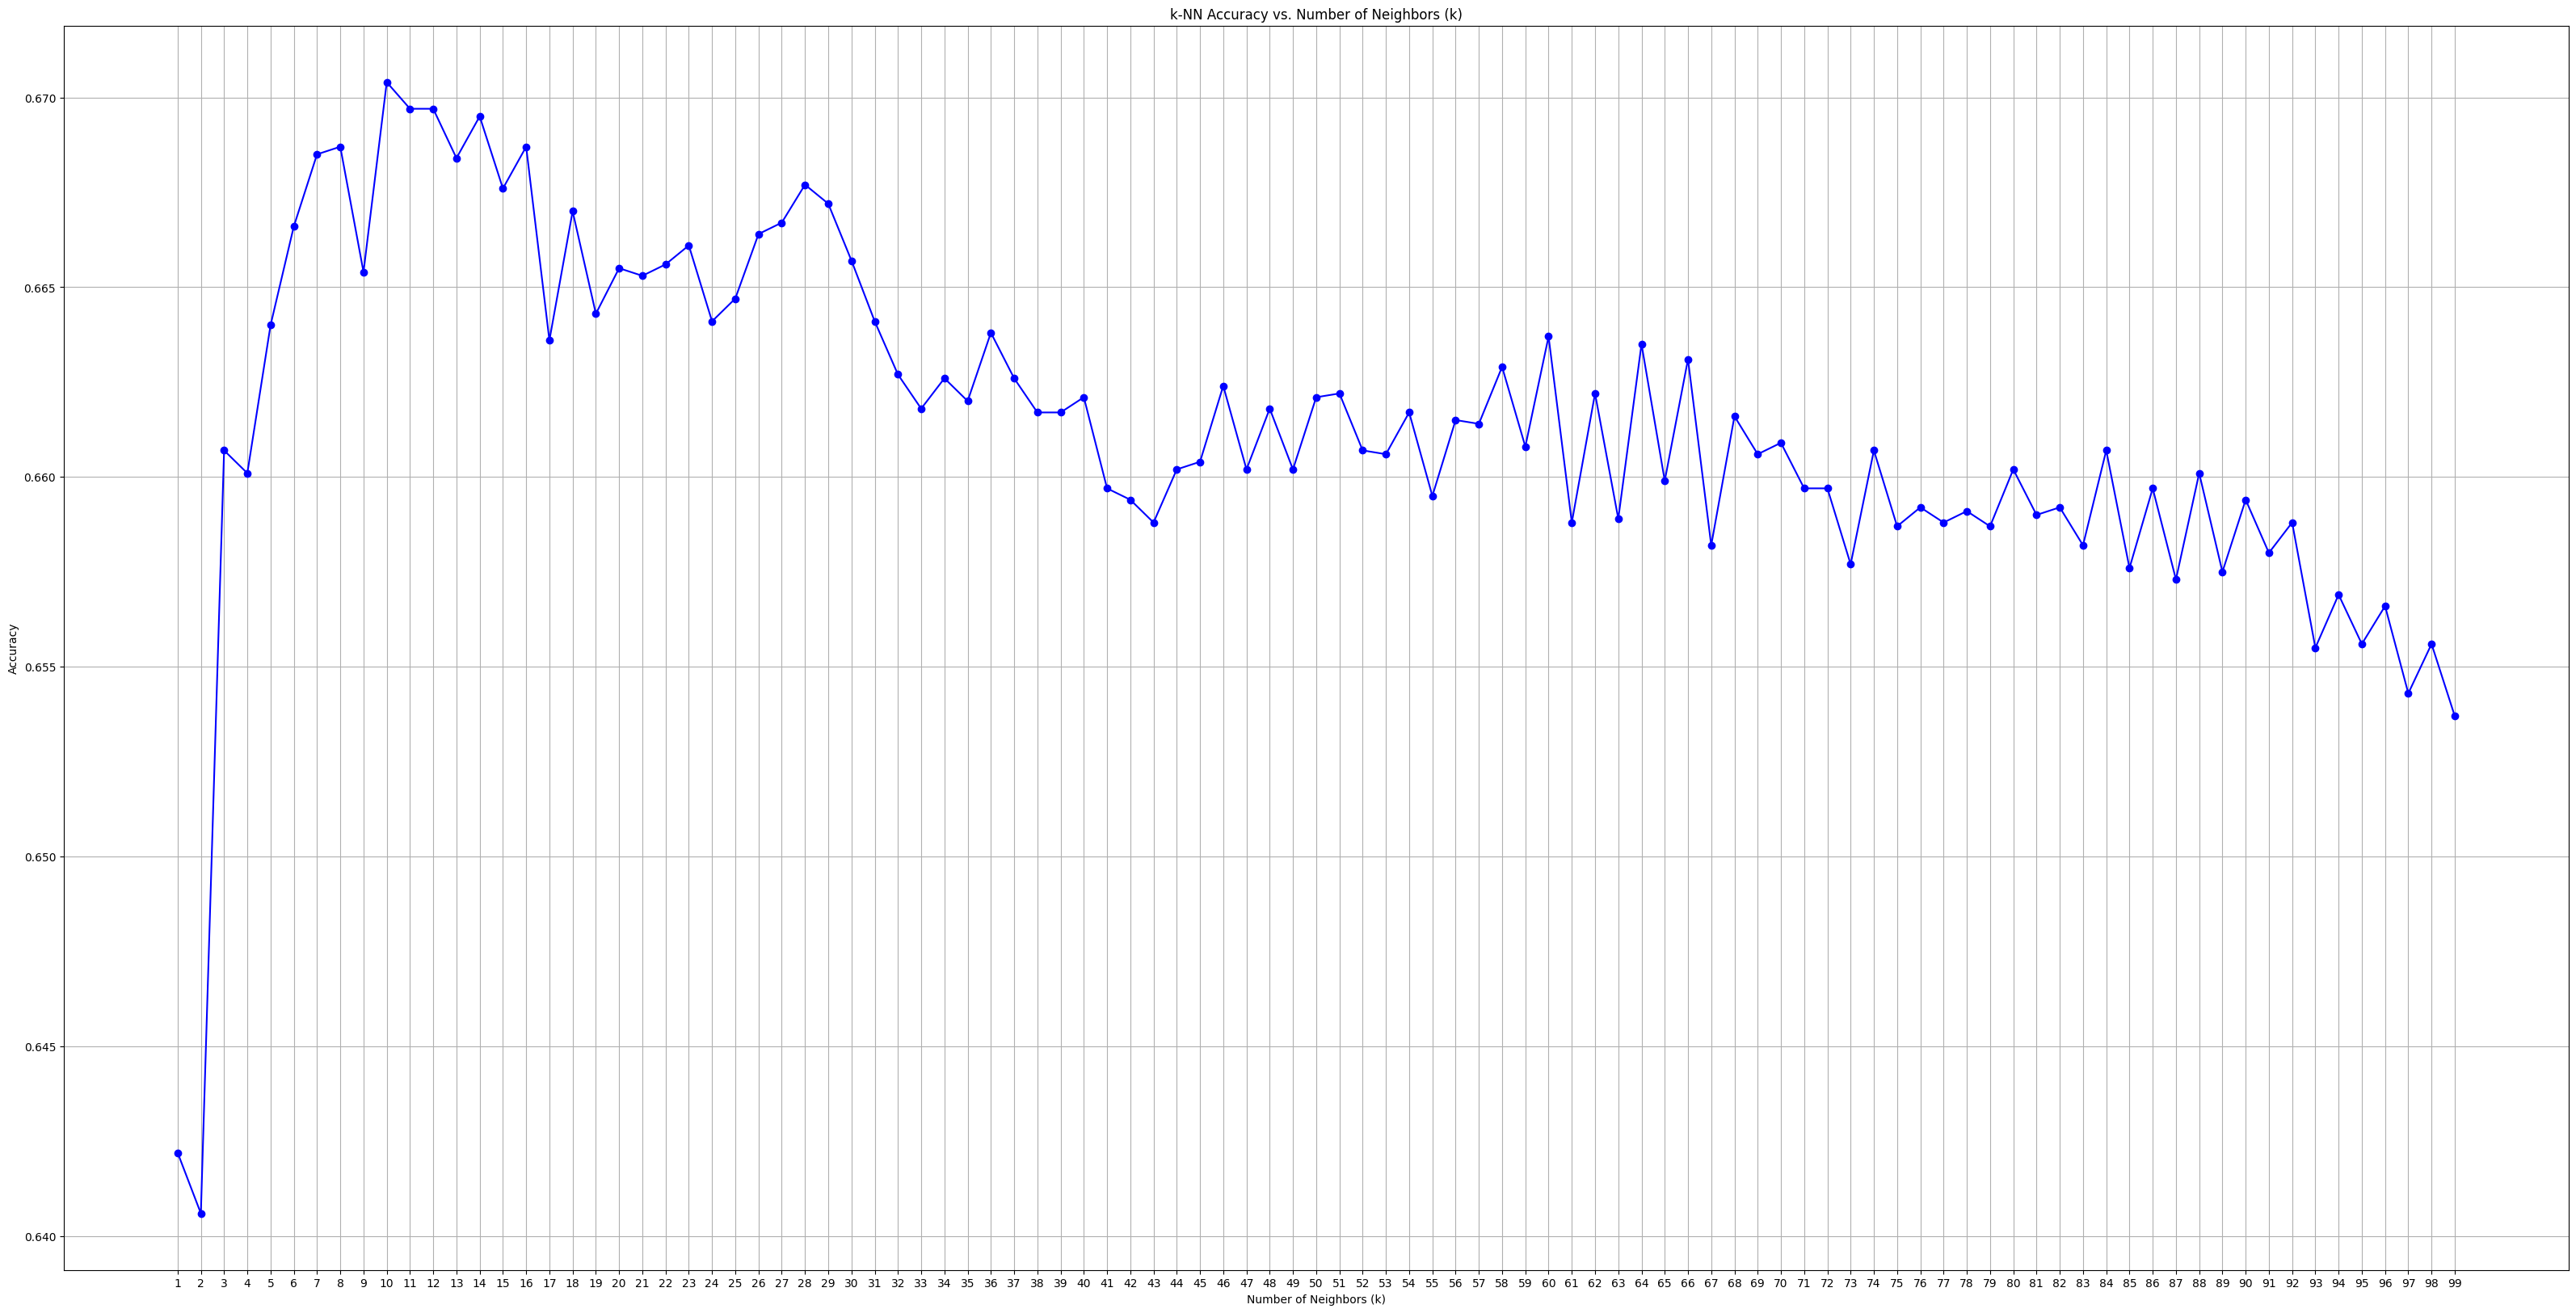

,K-Value,Accuracy
1,1,0.6422
2,2,0.6406
3,3,0.6607
4,4,0.6601
5,5,0.6640
...,...,...
95,95,0.6556
96,96,0.6566
97,97,0.6543
98,98,0.6556


In [13]:
k_values = range(1, 100)
accuracies = []

import matplotlib.pyplot as plty                                    

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    # print(f"Accuracy for k={k}: {accuracy}")  
            
accuracies_df = pd.DataFrame({"K-Value":k_values,"Accuracy": accuracies},index=k_values)


plty.figure(figsize=(40,20))
plty.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plty.title('k-NN Accuracy vs. Number of Neighbors (k)')
plty.xlabel('Number of Neighbors (k)')
plty.ylabel('Accuracy')
plty.xticks(k_values)

plty.grid(True)
plty.show()

accuracies_df   

In [ ]:
from sklearn.metrics import  confusion_matrix,precision_score,recall_score,f1_score

conf_mat = confusion_matrix(y_train,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f_score = f1_score(y_test,y_pred)

print(f"Confusion Matrix:\n{conf_mat}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f_score}")

Confusion Matrix:
[[1465 3501]
 [1554 3480]]
Precision: 0.6193955020770663
Recall: 0.8707209021345147
F1 Score: 0.7238637314807065
